In [1]:
import numpy as np
import matplotlib.pyplot as plt


filename_list = ['2021-03-04_rIAPP_2n5_sliceB_0V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_10V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_20V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_30V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_40V_02_dt_extracted.txt',
                 '2021-03-04_rIAPP_2n5_sliceB_50V_02_dt_extracted.txt']

datastore = {}
for filename in filename_list:
    with open (filename, 'r') as f:
        filenameparts = filename.split('_')
        voltage = filenameparts[4].replace('V', '')
        voltage = int(voltage)
        arrtime = []
        intensity = []
        for dataline in f:
            dataline = dataline.replace('\n', '')
            arrtime_intensity = dataline.split('\t')
            arrtime.append(float(arrtime_intensity[0]))
            intensity.append(float(arrtime_intensity[1]))         
            pairs = list(zip(arrtime, intensity))
        datastore[voltage] = pairs
        
intensity0 = [0]*200
pairs0 = list(zip(arrtime, intensity0))
datastore[-10] = pairs0

In [2]:
arrts_for2d = []
intens_for2d = []
volts_for2d = []

for k, pair in sorted(datastore.items()):
    for i in pair:
        arrts_for2d.append(i[0])
        intens_for2d.append(i[1])
        volts_for2d.append(k)
                

-10


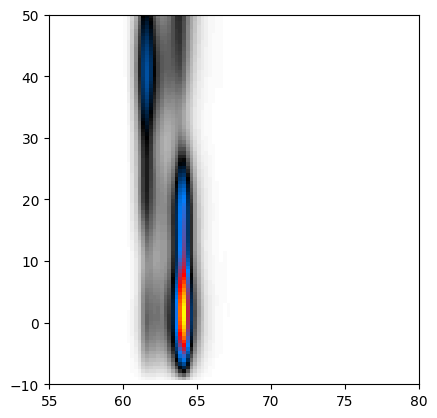

In [3]:
from scipy.interpolate import interp2d, RectBivariateSpline, CloughTocher2DInterpolator
from matplotlib.colors import LinearSegmentedColormap

X2d = np.array(sorted(set(arrts_for2d))) #flat list
Y2d = np.array(sorted(set(volts_for2d))) #flat list 0 to 70 once
Z2d = np.array(intens_for2d)
Z2d = Z2d.reshape(len(Y2d), len(X2d)).T

x_grid, y_grid = np.meshgrid(X2d, Y2d) # n_grid , n_grid of coordinates
x_grid_flat = x_grid.ravel()  # Flatten to list
y_grid_flat = y_grid.ravel() 
stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs

ztest = Z2d.T.ravel()
nz = ztest.nonzero()

interp_func = CloughTocher2DInterpolator(stacked_points, ztest) # , kernel='gaussian', epsilon=0.1)

X_max = 80
X_min = X2d.min()
Y_min = Y2d.min()
Y_max = 50

print(Y_min)

n_smooth = 100

X2d_plot = np.linspace(X_min, X_max, n_smooth)
Y2d_plot = np.linspace(Y_min, Y_max, n_smooth) 
#print(Y2d_plot)

x_grid, y_grid = np.meshgrid(X2d_plot, Y2d_plot) # n_grid , n_grid of coordinates
x_grid_flat = x_grid.ravel()  # Flatten to list
y_grid_flat = y_grid.ravel() 
stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs

Intens2d_plot = interp_func(stacked_points).reshape(n_smooth, n_smooth)
Intens2d_plot = np.clip(Intens2d_plot, a_min = 0, a_max = None)

density_colormap = LinearSegmentedColormap.from_list(name='density', colors=['#FFFFFF', '#000000','#0080FF','#FF0000','#FFFF00'], N=256)

fig, ax = plt.subplots()
x_range = (X_min, X_max) #min and max, effectively, cos it's sorted
y_range = (Y_min, Y_max)

aspect = (x_range[1] - x_range[0])/(y_range[1] - y_range[0])

ax.imshow(Intens2d_plot, cmap=density_colormap, origin='lower', extent=x_range + y_range, aspect=aspect, vmin=0.0)
plt.show()

In [4]:
Volts_new = Y2d_plot # np.linspace(0, 70, 200)

n,m = Intens2d_plot.shape

x_smootharrT_coords = []
y_smoothV_coords = []
smooth_intensities = []

for i in range(n):
    for j in range(m):
        intensity_value = int(Intens2d_plot[j,i])
        x_smootharrT_coords.append(X2d_plot[i])        
        y_smoothV_coords.append(Volts_new[j])
        smooth_intensities.append(intensity_value)

smoothxycoords = list(zip(x_smootharrT_coords, y_smoothV_coords))
smoothxycoords = np.array(smoothxycoords)
smooth_intensities = np.array(smooth_intensities)

In [7]:
import pomegranate
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution, IndependentComponentsDistribution, NormalDistribution
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict

class MinStdNormalDistributionX(NormalDistribution):
    def __init__(self, *args, **kw):
        kw['min_std'] = 0 #0.4 #0.1 #0.8 #1 #2#0.6
        NormalDistribution.__init__(self, *args, **kw)
class MinStdNormalDistributionY(NormalDistribution):
    def __init__(self, *args, **kw):
        kw['min_std'] = 0 #7 #8 #1 #5#11 ##stick w 10
        NormalDistribution.__init__(self, *args, **kw)

test_n_components = [2,3,4,5,6,7,8,9,10]

gmmlist = [] #objects for each components
master_bic_list = []
master_rmsd_list = []
n_runs = [1,2,3,4,5]

for n_run in n_runs:
    bic_list = []
    rmsd_list = []
    for i, n_comp in enumerate(test_n_components):

        gmm = GeneralMixtureModel.from_samples([MinStdNormalDistributionX, MinStdNormalDistributionY],
                                             n_comp, smoothxycoords, smooth_intensities, n_init=1, max_kmeans_iterations=50, 
                                              stop_threshold=0.1, verbose=False) #removed lr_decay
        gmmlist.append(gmm)
        df = (5 * n_comp) - 1
        lp = (gmm.log_probability(smoothxycoords) * smooth_intensities).sum() #sum, as in log space, normally porbs would multiply. 
        bic = float(df * np.log(len(smoothxycoords)) - 2.0 * lp) # For evaluating best n_comp
        bic_list.append(bic)
        
        comp_params = [comp.parameters[0] for comp in gmm.distributions] # Selects IndependentComponentsDistribution for each Gaussian
        x_params = [cp[0].parameters for cp in comp_params] # NormalDistribution for X : Mean, Var pairs
        y_params = [cp[1].parameters for cp in comp_params] # NormalDistribution for Y : Mean, Var pairs

        x_vals_mean, x_vals_var = zip(*x_params) 
        y_vals_mean, y_vals_var = zip(*y_params) 

      # Sqrt for Var to Std
        x_vals_std = np.sqrt(x_vals_var)
        y_vals_std = np.sqrt(y_vals_var)

        x_points = X2d_plot # np.linspace(X_min, X_max, n_grid) 
        y_points = Y2d_plot # np.linspace(Y_min, Y_max, n_grid)

        x_grid, y_grid = np.meshgrid(x_points, y_points) # n_grid , n_grid of smoothxycoords
        x_grid_flat = x_grid.ravel()  # Flatten to list
        y_grid_flat = y_grid.ravel() 
        stacked_points = np.stack([x_grid_flat, y_grid_flat], axis=1) # to get x,y pairs

        density = gmmlist[i].log_probability(stacked_points) # comes as log probabilties
        density = np.exp(density) # Real probs
        density_2d = density.reshape([len(x_points), len(y_points)]) # Restore points grid (of heights)

        norm_orig = Intens2d_plot/Intens2d_plot.sum()
        norm_pred = density_2d/density_2d.sum()
        
        resid = np.subtract(norm_orig, norm_pred)
        resid_sqs = resid * resid
        mean_sqs = np.mean(resid_sqs)
        rmsd = np.sqrt(mean_sqs)
        rmsd_list.append(rmsd)
    
    master_rmsd_list.append(rmsd_list)
    master_bic_list.append(bic_list)

master_gradient_list = []
for listy in master_bic_list:
    gradlist = []
    for i in range(0, len(listy)-1):
        grad = listy[i+1] - listy[i]
        gradlist.append(grad)
    master_gradient_list.append(gradlist)

In [8]:
import numpy as np

bic_arrays = [np.array(blist) for blist in master_bic_list]
bic_means = [np.mean(b) for b in zip(*bic_arrays)]
bic_std = [np.std(b, ddof=1) for b in zip(*bic_arrays)]

gradient_arrays = [np.array(glist) for glist in master_gradient_list]
gradient_means = [np.mean(g) for g in zip(*gradient_arrays)]
gradient_std = [np.std(g, ddof=1) for g in zip(*gradient_arrays)]

rmsd_arrays = [np.array(rlist) for rlist in master_rmsd_list]
rmsd_means = [np.mean(r) for r in zip(*rmsd_arrays)]
rmsd_std = [np.std(r, ddof=1) for r in zip(*rmsd_arrays)]

print(bic_means, bic_std)
print(gradient_means, gradient_std)
print(rmsd_means, rmsd_std)

[478251959.6913413, 469603912.0000824, 465683077.27334416, 463270448.6031321, 461511687.15008104, 460840499.4923956, 460307896.09993774, 459953615.14886695, 459749995.75907266] [0.03625864689129505, 0.0709699406230112, 412739.60341328126, 1614766.2499074284, 103540.43817312116, 330189.40048426174, 47314.0985235416, 223834.6057684668, 29187.808525183373]
[-8648047.691258812, -3920834.7267383337, -2412628.6702119946, -1758761.453051102, -671187.657685554, -532603.3924577951, -354280.95107076166, -203619.38979432583] [0.06196474019417721, 412739.5633209858, 1202026.6464941527, 1643711.5201499236, 279059.489757949, 341278.71066955547, 244383.81741002115, 252772.38384133857]
[0.0001609133703332616, 0.00010206281660390251, 9.035982102693015e-05, 6.56316425181253e-05, 6.352729415260587e-05, 4.5983617811015674e-05, 4.4005672533742824e-05, 4.394942062167135e-05, 4.283858806070043e-05] [0.0, 1.5152185993940876e-20, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


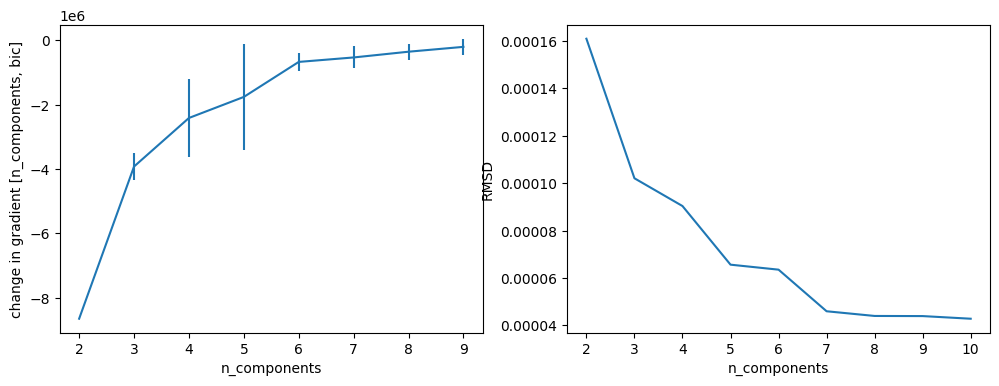

In [15]:

xg = [2,3,4,5,6,7,8,9]
xr = [2,3,4,5,6,7,8,9,10]
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.errorbar(xg, gradient_means, yerr=gradient_std)
ax1.set_ylabel('change in gradient [n_components, bic]')
ax1.set_xlabel('n_components')
ax2.errorbar(xr, rmsd_means, yerr=rmsd_std)
ax2.set_ylabel('RMSD')
ax2.set_xlabel('n_components')
plt.show()